## Bestpos For Reference 

In [1]:
import pandas as pd
# Paths to your ASCII files
position_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/testdata/test-bhostel/BESTPOS.ASCII"

def parse_position_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTPOSA'):
                parts = line.split(';')
                _, pos_data = parts[0], parts[1].split(',')
                lat = float(pos_data[2])
                lon = float(pos_data[3])
                alt = float(pos_data[4])
                status = pos_data[1]  # Extract the status
                data.append((lat, lon, alt, status))
    return pd.DataFrame(data, columns=['Latitude', 'Longitude', 'Altitude', 'Status'])
pd.set_option('display.precision', 12)
org_df=parse_position_data(position_file_path)
print(len(org_df))
print(org_df.head())


3289
         Latitude       Longitude  Altitude      Status
0  17.60121450934  78.12661698373  528.2726  NARROW_INT
1  17.60121450345  78.12661701459  528.2757  NARROW_INT
2  17.60121450275  78.12661701034  528.2741  NARROW_INT
3  17.60121450157  78.12661701588  528.2747  NARROW_INT
4  17.60121450125  78.12661700421  528.2747  NARROW_INT


## Testing IMU Datapaths

In [2]:
import pandas as pd
inspvax_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/testdata/test-bhostel/INSPVAX.ASCII"
coreimu_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/testdata/test-bhostel/CORRIMUDATA.ASCII"
vel_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/testdata/test-bhostel/BESTVEL.ASCII"

def parse_inspvax_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#INSPVAX'):
                parts = line.split(';')
                _, ins_data = parts[0].split(','), parts[1].split(',')
                roll = float(ins_data[9])
                pitch = float(ins_data[10])
                azimuth = float(ins_data[11])
                data.append((roll, pitch, azimuth))

    df = pd.DataFrame(data, columns=['Roll', 'Pitch', 'Azimuth'])
    return df

def parse_coreimu_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#CORRIMUDATA'):
                _, fields = line.split(';')
                fields = fields.split(',')
                acc_x = float(fields[5])
                acc_y = float(fields[6])
                acc_z = float(fields[7].split('*')[0])
                data.append((acc_x, acc_y, acc_z))

    df = pd.DataFrame(data, columns=['Acc_x', 'Acc_y', 'Acc_z'])
    return df

def parse_bestvel_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTVELA'):
                time_data, fields = line.split(';')
                fields = fields.split(',')
                hor_speed = float(fields[4])
                trk_ground = float(fields[5])
                data.append((hor_speed, trk_ground))

    df = pd.DataFrame(data, columns=['Hor_speed', 'Trk_ground'])
    return df

# Parse data from each file
ins_df = parse_inspvax_data(inspvax_file_path)
acc_df = parse_coreimu_data(coreimu_file_path)
vel_df = parse_bestvel_data(vel_file_path)
pd.set_option('display.precision', 12)
print(len(ins_df),len(acc_df),len(vel_df))
# Check lengths and merge dataframes
if len(ins_df) == len(acc_df)==len(vel_df):
    final_df = pd.concat([ins_df, acc_df, vel_df], axis=1)
else:
    print("Data mismatch in length; check synchronization and sampling rates.")
print(final_df.head())
final_df=final_df.dropna()


3289 3289 3289
          Roll        Pitch        Azimuth           Acc_x           Acc_y  \
0  0.460417761 -1.484544179  175.560869792 -0.000269023551  0.000562388827   
1  0.458898969 -1.485094645  175.561333129  0.000369112252  0.000254499022   
2  0.459622935 -1.486195445  175.560668543  0.000036748824  0.000138154025   
3  0.459987471 -1.484887692  175.560641021 -0.000385047266 -0.000024928182   
4  0.460249483 -1.484448486  175.561713270 -0.000301648210  0.000294308346   

            Acc_z  Hor_speed  Trk_ground  
0 -0.000517364123     0.0068  251.966872  
1  0.000222701816     0.0169   88.210510  
2 -0.000087128681     0.0130    1.349526  
3 -0.000025557797     0.0100  175.212681  
4  0.000261731486     0.0036   90.161674  


## Random Forest Model Testing

In [12]:
import joblib
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import folium
# Define features
# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'
target_alt = 'Delta_Altitude'

# Load the trained Random Forest models for latitude and longitude prediction
rf_regressor_lat_loaded = joblib.load('rf_regressor_lat_model.pkl')
rf_regressor_lon_loaded = joblib.load('rf_regressor_lon_model.pkl')
rf_regressor_alt_loaded = joblib.load('rf_regressor_alt_model.pkl')


# Predict changes in latitude using the loaded model
pred_lat_diff_loaded = rf_regressor_lat_loaded.predict(final_df[features])

# Predict changes in longitude using the loaded model
pred_lon_diff_loaded = rf_regressor_lon_loaded.predict(final_df[features])

# Predict changes in altitude using the loaded model
pred_alt_diff_loaded = rf_regressor_alt_loaded.predict(final_df[features])


random_latitudes= []
random_longitudes = []
random_altitudes= []                    


# Example of using the models to predict position during GNSS outage for each test data point
# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0], org_df['Altitude'].iloc[0]])

for i in range(len(pred_lat_diff_loaded)):
    latitude_change = pred_lat_diff_loaded[i]
    longitude_change = pred_lon_diff_loaded[i]
    altitude_change = pred_alt_diff_loaded[i]
    current_position = last_known_position + np.array([latitude_change, longitude_change, altitude_change])
    last_known_position=current_position
    # Append the modified latitude and longitude values to the lists
    random_latitudes.append(current_position[0])
    random_longitudes.append(current_position[1])
    random_altitudes.append(current_position[2])

# Function to determine color based on status
def get_marker_color(status):
    if status == 'NARROW_INT':
        return 'green'
    elif status == 'INS_RTKFIXED':
        return 'yellow'
    else:
        return 'red'

# Create a folium map centered at the mean of the original data points
m = folium.Map(
    location=[np.mean(org_df['Latitude']), np.mean(org_df['Longitude'])], 
    zoom_start=18,  # Set the zoom level similar to Google Maps
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google'
)

# Add data points to the map with color coding based on status
for lat, lon, status in zip(org_df['Latitude'], org_df['Longitude'], org_df['Status']):
    color = get_marker_color(status)
    folium.CircleMarker(
        location=[lat, lon],
        radius=1,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        weight=0.1,
        popup=f'Status: {status}'
    ).add_to(m)

# Add predicted data points to the map with reduced marker size
for lat, lon in zip(random_latitudes, random_longitudes):
    folium.CircleMarker(
        location=[lat, lon],
        radius=0.1,  # Reduce radius for smaller markers
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        weight=0.1,
        popup='Predicted'
    ).add_to(m)

# Save the map as an HTML file
m.save('/Users/ravitejakunchanapalli/Desktop/test-color(rf).html')



3289
3289


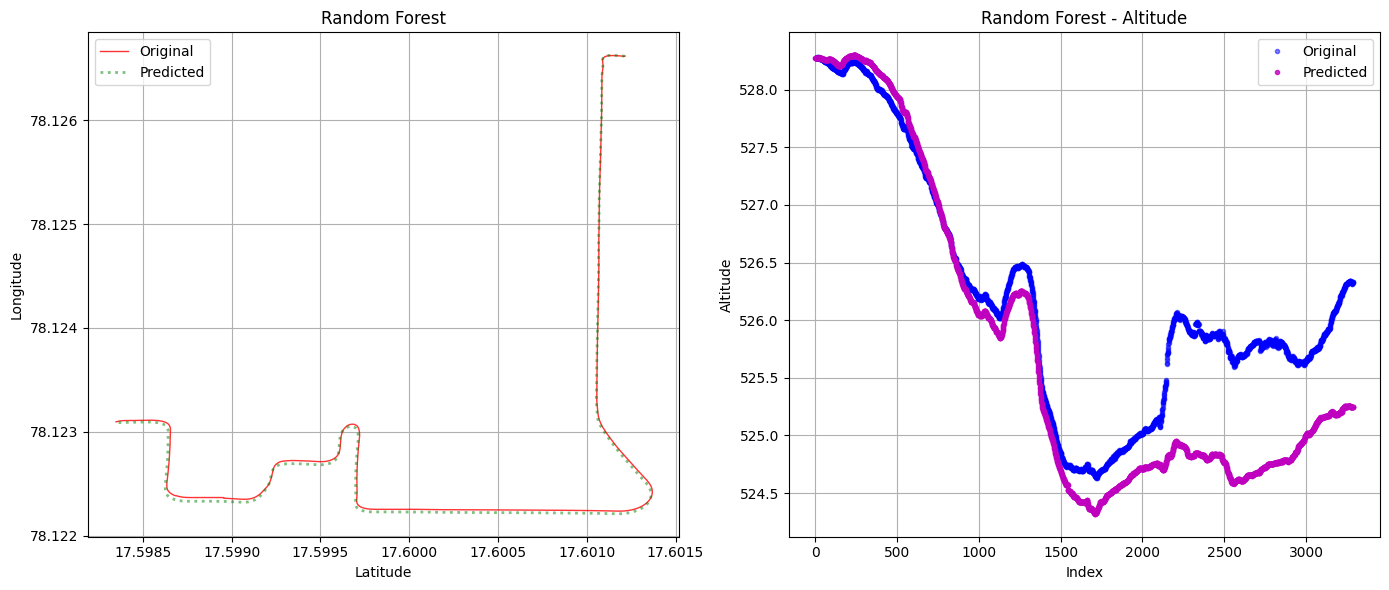

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Ensure you have the correct lengths
print(len(org_df['Latitude']))
print(len(random_latitudes))

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Delta_Latitude on the first subplot
axs[0].plot(org_df['Latitude'], org_df['Longitude'], 'r', label='Original', linewidth=1, alpha=0.8)
axs[0].plot(random_latitudes, random_longitudes, 'g:', linewidth=2, label='Predicted', alpha=0.5)
axs[0].set_xlabel('Latitude')
axs[0].set_ylabel('Longitude')
axs[0].set_title('Random Forest')
axs[0].legend()
axs[0].grid(True)  # Enable grid for the first subplot
axs[0].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))

# Plotting altitude data on the second subplot
axs[1].plot(org_df.index, org_df['Altitude'], 'b.', label='Original', linewidth=2, alpha=0.5)
axs[1].plot(org_df.index, random_altitudes, 'm.', label='Predicted', linewidth=1, alpha=0.8)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Altitude')
axs[1].set_title('Random Forest - Altitude')
axs[1].legend()
axs[1].grid(True)  # Enable grid for the second subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


## LightGBM Model Testing

In [ ]:
import joblib
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Define features
# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Load the trained Random Forest models for latitude and longitude prediction
rf_regressor_lat_loaded = joblib.load('lightgbm_lat_model.pkl')
rf_regressor_lon_loaded = joblib.load('lightgbm_lon_model.pkl')

# Predict changes in latitude using the loaded model
pred_lat_diff_loaded = rf_regressor_lat_loaded.predict(final_df[features])

# Predict changes in longitude using the loaded model
pred_lon_diff_loaded = rf_regressor_lon_loaded.predict(final_df[features])

random_latitudes= []
random_longitudes = []
                    
# Example of using the models to predict position during GNSS outage for each test data point
# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0]])
for i in range(len(pred_lat_diff_loaded)):
    latitude_change = pred_lat_diff_loaded[i]
    longitude_change = pred_lon_diff_loaded[i]
    current_position = last_known_position + np.array([latitude_change, longitude_change])
    last_known_position=current_position
    # Append the modified latitude and longitude values to the lists
    random_latitudes.append(current_position[0])
    random_longitudes.append(current_position[1])


# Plot original and predicted values for Latitude and Longitude Values
plt.figure(figsize=(10, 6))
print(len(org_df['Latitude']))
print(len(random_latitudes))
plt.plot(org_df['Latitude'], org_df['Longitude'],'r', label='Original',  linewidth=1, alpha=0.8)
plt.plot(random_latitudes, random_longitudes,'g:', linewidth=2,label='Predicted',  alpha=0.5)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.xlabel('Lat')
plt.ylabel('Long')
plt.title('LightGBM')
plt.legend()
plt.grid(True) 
plt.show()


## CatBoost

In [ ]:
import joblib
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Define features
# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Load the trained Random Forest models for latitude and longitude prediction
rf_regressor_lat_loaded = joblib.load('catboost_lat_model.pkl')
rf_regressor_lon_loaded = joblib.load('catboost_lon_model.pkl')

# Predict changes in latitude using the loaded model
pred_lat_diff_loaded = rf_regressor_lat_loaded.predict(final_df[features])

# Predict changes in longitude using the loaded model
pred_lon_diff_loaded = rf_regressor_lon_loaded.predict(final_df[features])

random_latitudes= []
random_longitudes = []
                    
# Example of using the models to predict position during GNSS outage for each test data point
# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0]])
for i in range(len(pred_lat_diff_loaded)):
    latitude_change = pred_lat_diff_loaded[i]
    longitude_change = pred_lon_diff_loaded[i]
    current_position = last_known_position + np.array([latitude_change, longitude_change])
    last_known_position=current_position
    # Append the modified latitude and longitude values to the lists
    random_latitudes.append(current_position[0])
    random_longitudes.append(current_position[1])


# Plot original and predicted values for Latitude and Longitude Values
plt.figure(figsize=(10, 6))
print(len(org_df['Latitude']))
print(len(random_latitudes))
plt.plot(org_df['Latitude'], org_df['Longitude'],'r', label='Original',  linewidth=1, alpha=0.8)
plt.plot(random_latitudes, random_longitudes,'g:', linewidth=2,label='Predicted',  alpha=0.5)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.xlabel('Lat')
plt.ylabel('Long')
plt.title('CatBoost')
plt.legend()
plt.grid(True) 
plt.show()


## Gradient Boosting

In [ ]:
import joblib
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Define features
# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Load the trained Random Forest models for latitude and longitude prediction
rf_regressor_lat_loaded = joblib.load('gradient-boost_lat_model.pkl')
rf_regressor_lon_loaded = joblib.load('gradient-boost_lat_model.pkl')

# Predict changes in latitude using the loaded model
pred_lat_diff_loaded = rf_regressor_lat_loaded.predict(final_df[features])

# Predict changes in longitude using the loaded model
pred_lon_diff_loaded = rf_regressor_lon_loaded.predict(final_df[features])

random_latitudes= []
random_longitudes = []
                    
# Example of using the models to predict position during GNSS outage for each test data point
# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0]])
for i in range(len(pred_lat_diff_loaded)):
    latitude_change = pred_lat_diff_loaded[i]
    longitude_change = pred_lon_diff_loaded[i]
    current_position = last_known_position + np.array([latitude_change, longitude_change])
    last_known_position=current_position
    # Append the modified latitude and longitude values to the lists
    random_latitudes.append(current_position[0])
    random_longitudes.append(current_position[1])


# Plot original and predicted values for Latitude and Longitude Values
plt.figure(figsize=(10, 6))
print(len(org_df['Latitude']))
print(len(random_latitudes))
plt.plot(org_df['Latitude'], org_df['Longitude'],'r', label='Original',  linewidth=1, alpha=0.8)
plt.plot(random_latitudes, random_longitudes,'g:', linewidth=2,label='Predicted',  alpha=0.5)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.xlabel('Lat')
plt.ylabel('Long')
plt.title('Gradient Boosting')
plt.legend()
plt.grid(True) 
plt.show()


## All Model Plots

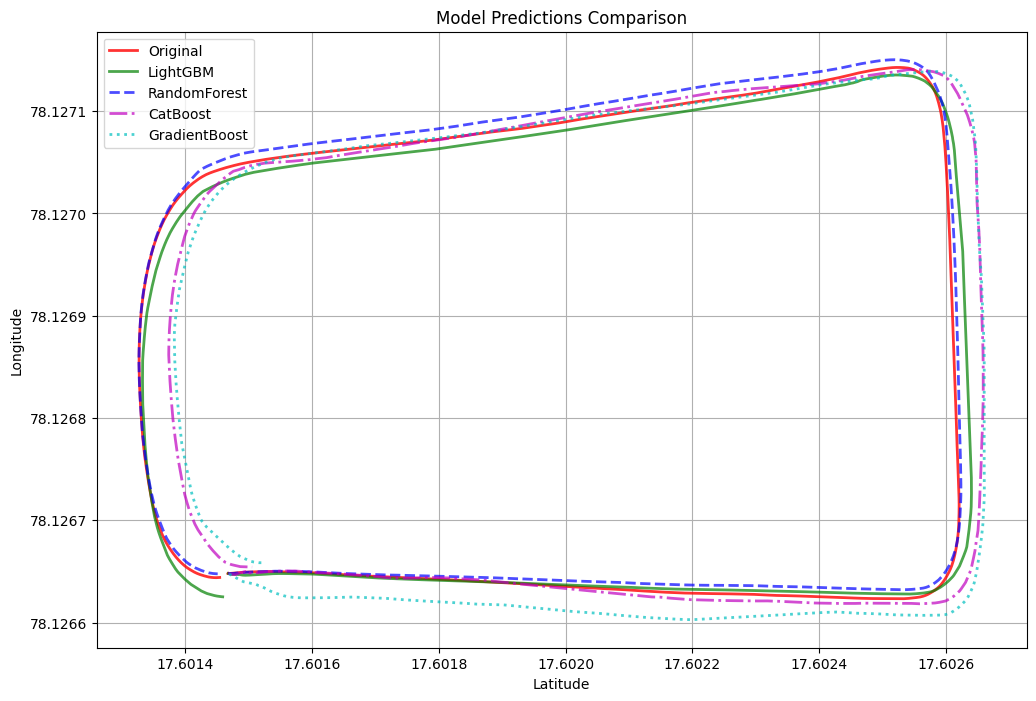

In [5]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Load the trained models for latitude and longitude prediction
model_files = {
    'LightGBM': ('lightgbm_lat_model.pkl', 'lightgbm_lon_model.pkl'),
    'RandomForest': ('rf_regressor_lat_model.pkl', 'rf_regressor_lon_model.pkl'),
    'CatBoost': ('catboost_lat_model.pkl', 'catboost_lon_model.pkl'),
    'GradientBoost': ('gradient-boost_lat_model.pkl', 'gradient-boost_lon_model.pkl')
}

# Function to predict positions using the given model
def predict_positions(lat_model, lon_model, features, last_known_position):
    pred_lat_diff = lat_model.predict(features)
    pred_lon_diff = lon_model.predict(features)
    latitudes, longitudes = [], []
    
    current_position = last_known_position
    for lat_diff, lon_diff in zip(pred_lat_diff, pred_lon_diff):
        current_position = current_position + np.array([lat_diff, lon_diff])
        latitudes.append(current_position[0])
        longitudes.append(current_position[1])
    
    return latitudes, longitudes

# Initialize dictionaries to store the predictions
predictions = {}

# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0]])

# Generate predictions for each model
for model_name, (lat_model_file, lon_model_file) in model_files.items():
    lat_model = joblib.load(lat_model_file)
    lon_model = joblib.load(lon_model_file)
    latitudes, longitudes = predict_positions(lat_model, lon_model, final_df[features], last_known_position)
    predictions[model_name] = (latitudes, longitudes)

# Define colors and styles for each model
colors = {
    'LightGBM': ('g', '-'),
    'RandomForest': ('b', '--'),
    'CatBoost': ('m', '-.'),
    'GradientBoost': ('c', ':')
}

# Plot original and predicted values for Latitude and Longitude
plt.figure(figsize=(12, 8))
plt.plot(org_df['Latitude'], org_df['Longitude'], 'r', label='Original', linewidth=2, alpha=0.8)

# Plot predictions for each model with distinct styles
for model_name, (latitudes, longitudes) in predictions.items():
    color, style = colors[model_name]
    plt.plot(latitudes, longitudes, style, color=color, linewidth=2, label=model_name, alpha=0.7)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=False))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Model Predictions Comparison')
plt.legend()
plt.grid(True)
plt.show()


## Folium maps all models

In [ ]:
import folium
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth', 'Acc_x', 'Acc_y', 'Acc_z', 'Hor_speed', 'Trk_ground']
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Load the trained models for latitude and longitude prediction
model_files = {
    'LightGBM': ('lightgbm_lat_model.pkl', 'lightgbm_lon_model.pkl'),
    'RandomForest': ('rf_regressor_lat_model.pkl', 'rf_regressor_lon_model.pkl'),
    'CatBoost': ('catboost_lat_model.pkl', 'catboost_lon_model.pkl'),
    'GradientBoost': ('gradient-boost_lat_model.pkl', 'gradient-boost_lon_model.pkl')
}

# Function to predict positions using the given model
def predict_positions(lat_model, lon_model, features, last_known_position):
    pred_lat_diff = lat_model.predict(features)
    pred_lon_diff = lon_model.predict(features)
    latitudes, longitudes = [], []
    
    current_position = last_known_position
    for lat_diff, lon_diff in zip(pred_lat_diff, pred_lon_diff):
        current_position = current_position + np.array([lat_diff, lon_diff])
        latitudes.append(current_position[0])
        longitudes.append(current_position[1])
    
    return latitudes, longitudes

# Initialize dictionaries to store the predictions
predictions = {}

# Assuming last_known_position is the last known GNSS position
last_known_position = np.array([org_df['Latitude'].iloc[0], org_df['Longitude'].iloc[0]])

# Generate predictions for each model
for model_name, (lat_model_file, lon_model_file) in model_files.items():
    lat_model = joblib.load(lat_model_file)
    lon_model = joblib.load(lon_model_file)
    latitudes, longitudes = predict_positions(lat_model, lon_model, final_df[features], last_known_position)
    predictions[model_name] = (latitudes, longitudes)

# Define colors for each model
colors = {
    'LightGBM': 'green',
    'RandomForest': 'blue',
    'CatBoost': 'magenta',
    'GradientBoost': 'cyan'
}

# Create a folium map
m = folium.Map(
    location=[np.mean(org_df['Latitude']), np.mean(org_df['Longitude'])], 
    zoom_start=18,  # Set the zoom level similar to Google Maps
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google'
)

# Plot original data points
for lat, lon in zip(org_df['Latitude'], org_df['Longitude']):
    folium.CircleMarker(
        location=[lat, lon],
        radius=0.1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        weight=0.1,
        popup='Original'
    ).add_to(m)

# Plot predictions for each model
for model_name, (latitudes, longitudes) in predictions.items():
    for lat, lon in zip(latitudes, longitudes):
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            color=colors[model_name],
            fill=True,
            fill_opacity=0.5,
            weight=0.1,
            fill_color=colors[model_name],
            popup=model_name
        ).add_to(m)

# Save the map as an HTML file
m.save('/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)/testdata/4models-folium.html')


## Color testing

In [16]:
# Function to determine color based on status
def get_marker_color(status):
    if status == 'NARROW_INT':
        return 'green'
    elif status == 'INS_RTKFIXED':
        return 'yellow'
    else:
        return 'red'

# Create a folium map centered at the mean of the original data points
m = folium.Map(
    location=[np.mean(org_df['Latitude']), np.mean(org_df['Longitude'])], 
    zoom_start=18,  # Set the zoom level similar to Google Maps
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google'
)

# Add data points to the map with color coding based on status
for lat, lon, status in zip(org_df['Latitude'], org_df['Longitude'], org_df['Status']):
    color = get_marker_color(status)
    folium.CircleMarker(
        location=[lat, lon],
        radius=1,
        color=color,
        fill=True,
        fill_color=color,
        popup=f'Status: {status}'
    ).add_to(m)

# Save the map as an HTML file
output_path = '/Users/ravitejakunchanapalli/Desktop/test-color.html'
m.save(output_path)

print(f"Map saved to {output_path}")

3289
         Latitude       Longitude      Status
0  17.60121450934  78.12661698373  NARROW_INT
1  17.60121450345  78.12661701459  NARROW_INT
2  17.60121450275  78.12661701034  NARROW_INT
3  17.60121450157  78.12661701588  NARROW_INT
4  17.60121450125  78.12661700421  NARROW_INT
Map saved to /Users/ravitejakunchanapalli/Desktop/test-color.html
